In [1]:
# Author: Remi Flamary <remi.flamary@unice.fr>
#         Kilian Fatras <kilian.fatras@irisa.fr>
#
# License: MIT License

import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

In [ ]:
def sinkhorn_knopp(a, b, M, reg, numItermax=1000,
                   stopThr=1e-9, verbose=False, log=False, **kwargs):

    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    M = np.asarray(M, dtype=np.float64)

    if len(a) == 0:
        a = np.ones((M.shape[0],), dtype=np.float64) / M.shape[0]
    if len(b) == 0:
        b = np.ones((M.shape[1],), dtype=np.float64) / M.shape[1]

    # init data
    dim_a = len(a)
    dim_b = len(b)

    if len(b.shape) > 1:
        n_hists = b.shape[1]
    else:
        n_hists = 0

    if log:
        log = {'err': []}

    # we assume that no distances are null except those of the diagonal of
    # distances
    if n_hists:
        u = np.ones((dim_a, n_hists)) / dim_a
        v = np.ones((dim_b, n_hists)) / dim_b
    else:
        u = np.ones(dim_a) / dim_a
        v = np.ones(dim_b) / dim_b

    # print(reg)

    # Next 3 lines equivalent to K= np.exp(-M/reg), but faster to compute
    K = np.empty(M.shape, dtype=M.dtype)
    np.divide(M, -reg, out=K)
    np.exp(K, out=K)

    # print(np.min(K))
    tmp2 = np.empty(b.shape, dtype=M.dtype)

    Kp = (1 / a).reshape(-1, 1) * K
    cpt = 0
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        KtransposeU = np.dot(K.T, u)
        v = np.divide(b, KtransposeU)
        u = 1. / np.dot(Kp, v)

        if (np.any(KtransposeU == 0)
                or np.any(np.isnan(u)) or np.any(np.isnan(v))
                or np.any(np.isinf(u)) or np.any(np.isinf(v))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Warning: numerical errors at iteration', cpt)
            u = uprev
            v = vprev
            break
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            if n_hists:
                np.einsum('ik,ij,jk->jk', u, K, v, out=tmp2)
            else:
                # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
                np.einsum('i,ij,j->j', u, K, v, out=tmp2)
            err = np.linalg.norm(tmp2 - b)  # violation of marginal
            if log:
                log['err'].append(err)

            if verbose:
                if cpt % 200 == 0:
                    print(
                        '{:5s}|{:12s}'.format('It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))
        cpt = cpt + 1
    if log:
        log['u'] = u
        log['v'] = v

    if n_hists:  # return only loss
        res = np.einsum('ik,ij,jk,ij->k', u, K, v, M)
        if log:
            return res, log
        else:
            return res

    else:  # return OT matrix

        if log:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1)), log
        else:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1))


In [2]:
#%% parameters and data generation

n = 50  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

Text(0.5, 1.0, 'Cost matrix M')

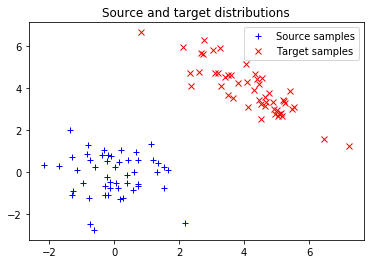

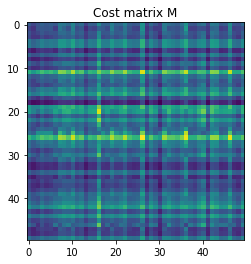

In [3]:
#%% plot samples

pl.figure(1)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(M, interpolation='nearest')
pl.title('Cost matrix M')

Text(0.5, 1.0, 'OT matrix with samples')

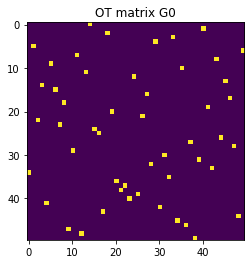

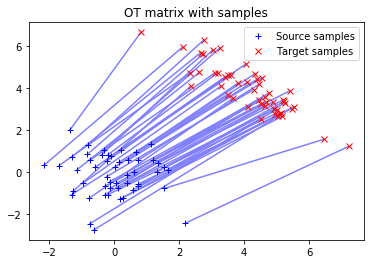

In [4]:
#%% EMD

G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

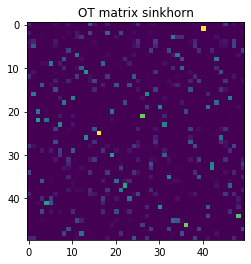

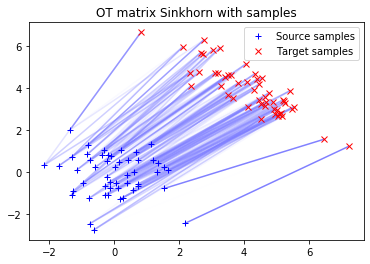

In [5]:
#%% sinkhorn

# reg term
lambd = 1e-3

Gs = ot.sinkhorn(a, b, M, lambd)

pl.figure(5)
pl.imshow(Gs, interpolation='nearest')
pl.title('OT matrix sinkhorn')

pl.figure(6)
ot.plot.plot2D_samples_mat(xs, xt, Gs, color=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix Sinkhorn with samples')

pl.show()
